Files already downloaded and verified


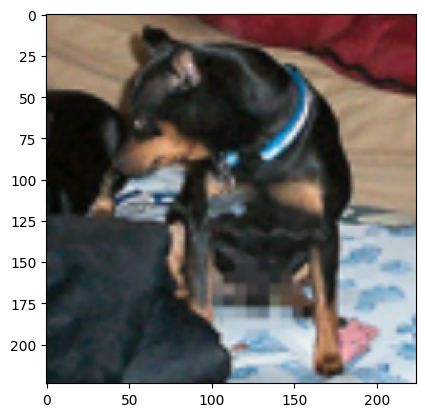

In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.utils import data
from torchvision.models import vgg19, resnet18, resnet152
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

# use the ImageNet transformation
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                               ])

dataset = torchvision.datasets.STL10(root = './c', split = 'test', transform = transform, download = True)
image_tensor = dataset.__getitem__(1900)[0]
plt.imshow(
    image_tensor.numpy().transpose(1,2,0)*[0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
)

In [11]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = vgg19(pretrained='VGG19_Weights.IMAGENET1K_V1')
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
        # shape after backpropagation : torch.Size([1, 512, 14, 14]) == vgg19(pretrained=True).features[:36](image_tensor.unsqueeze(0)).shape
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


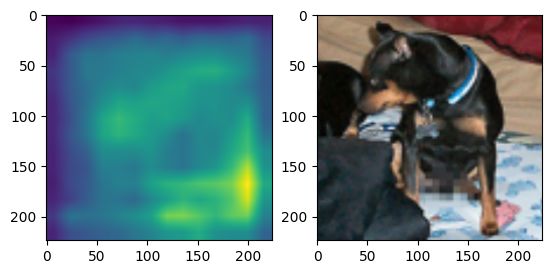

In [12]:
vgg = VGG()

# set the evaluation mode
vgg.eval()

# get the most likely prediction of the model
pred = vgg(image_tensor.unsqueeze(0))
pred.argmax(1)


pred[:, pred.argmax(1).item()].backward()

# pull the gradients out of the model
# torch.Size([1, 512, 14, 14])
gradients = vgg.get_activations_gradient()

# pool the gradients across the channels
# shape torch.Size([512])
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
# torch.Size([1, 512, 14, 14])
activations = vgg.get_activations(image_tensor.unsqueeze(0)).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
# torch.Size([14, 14])
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap

import cv2
heatmap = cv2.resize(np.array(heatmap), (224, 224))

plt.subplot(1,2,1)
plt.imshow(heatmap)
plt.subplot(1,2,2)
plt.imshow(
    image_tensor.numpy().transpose(1,2,0)*[0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
)

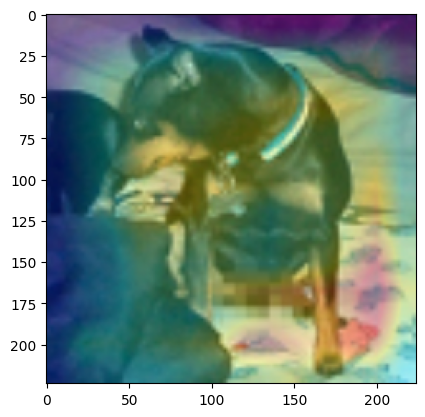

In [13]:
heatmap = np.uint8(255 * (1-heatmap))
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
plt.imshow(np.uint((image_tensor.numpy().transpose(1,2,0)*[0.229, 0.224, 0.225] + [0.485, 0.456, 0.406])*255))
plt.imshow(heatmap, alpha = 0.3)

In [14]:
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = resnet18(pretrained='ResNet18_Weights.IMAGENET1K_V1')
        self.encoder = torch.nn.Sequential(*(list(resnet.children())[:-2]))
        self.avgpool = resnet.avgpool
        
        self.classifier = resnet.fc
        
        self.gradients = None
    
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.encoder(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.avgpool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.encoder(x)

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


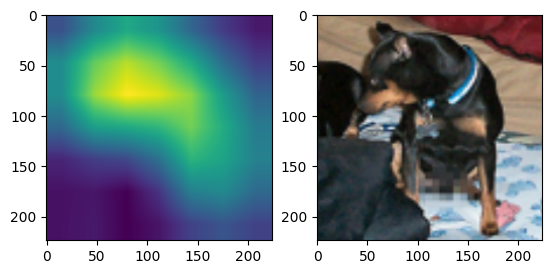

In [6]:
res18 = ResNet18()

# set the evaluation mode
res18.eval()

# get the most likely prediction of the model
pred = res18(image_tensor.unsqueeze(0))
pred.argmax(1)


pred[:, pred.argmax(1).item()].backward()

# pull the gradients out of the model
# torch.Size([1, 512, 14, 14])
gradients = res18.get_activations_gradient()

# pool the gradients across the channels
# shape torch.Size([512])
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
# torch.Size([1, 512, 14, 14])
activations = res18.get_activations(image_tensor.unsqueeze(0)).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
# torch.Size([14, 14])
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap

import cv2
heatmap = cv2.resize(np.array(heatmap), (224, 224))

plt.subplot(1,2,1)
plt.imshow(heatmap)
plt.subplot(1,2,2)
plt.imshow(
    image_tensor.numpy().transpose(1,2,0)*[0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
)

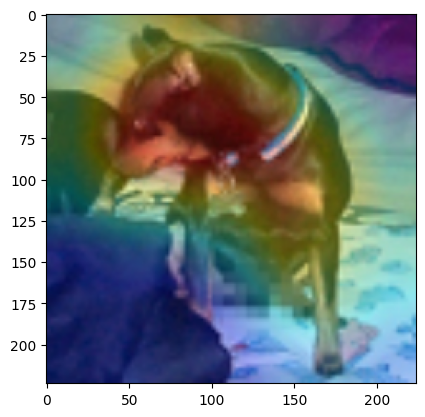

In [7]:
heatmap = np.uint8(255 * (1-heatmap))
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
plt.imshow(np.uint((image_tensor.numpy().transpose(1,2,0)*[0.229, 0.224, 0.225] + [0.485, 0.456, 0.406])*255))
plt.imshow(heatmap, alpha = 0.3)

In [8]:
class ResNet152(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = resnet152(pretrained='ResNet152_Weights.IMAGENET1K_V1')
        self.encoder = torch.nn.Sequential(*(list(resnet.children())[:-2]))
        self.avgpool = resnet.avgpool
        
        self.classifier = resnet.fc
        
        self.gradients = None
    
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.encoder(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.avgpool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.encoder(x)

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


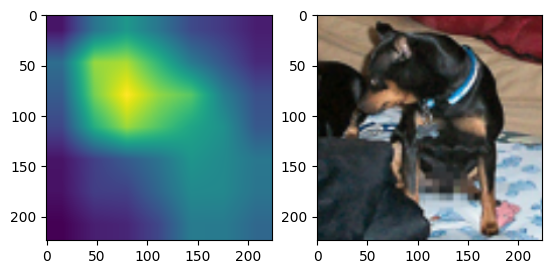

In [9]:
res18 = ResNet152()

# set the evaluation mode
res18.eval()

# get the most likely prediction of the model
pred = res18(image_tensor.unsqueeze(0))
pred.argmax(1)


pred[:, pred.argmax(1).item()].backward()

# pull the gradients out of the model
# torch.Size([1, 512, 14, 14])
gradients = res18.get_activations_gradient()

# pool the gradients across the channels
# shape torch.Size([512])
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
# torch.Size([1, 512, 14, 14])
activations = res18.get_activations(image_tensor.unsqueeze(0)).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
# torch.Size([14, 14])
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap

import cv2
heatmap = cv2.resize(np.array(heatmap), (224, 224))

plt.subplot(1,2,1)
plt.imshow(heatmap)
plt.subplot(1,2,2)
plt.imshow(
    image_tensor.numpy().transpose(1,2,0)*[0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
)

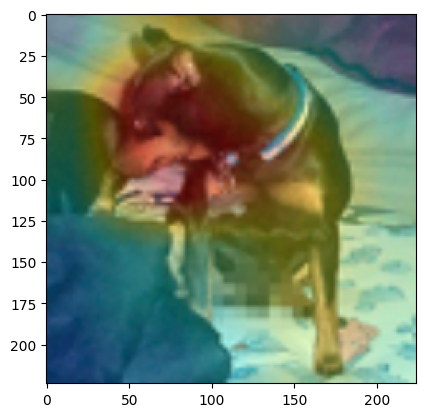

In [10]:
heatmap = np.uint8(255 * (1-heatmap))
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
plt.imshow(np.uint((image_tensor.numpy().transpose(1,2,0)*[0.229, 0.224, 0.225] + [0.485, 0.456, 0.406])*255))
plt.imshow(heatmap, alpha = 0.3)